> Get topics for each decade (folder-by-folder, basically)

References:<br>
https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/<br>
https://medium.com/dataseries/understanding-pointwise-mutual-information-in-nlp-e4ef75ecb57a<br>
https://www.baeldung.com/cs/topic-modeling-coherence-score

# Environment

In [1]:
%%capture
!pip install spacy
!pip install gensim
!pip install pyLDAvis
!python -m spacy download en_core_web_sm

In [2]:
import re
import spacy
import gensim
import string
import logging
import warnings
import pyLDAvis
import numpy as np
import pandas as pd
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
import gensim.corpora as corpora

from pprint import pprint
from nltk.corpus import stopwords
from gensim.models import CoherenceModel
from nltk.corpus import PlaintextCorpusReader
from gensim.parsing.preprocessing import preprocess_string

%matplotlib inline
pyLDAvis.enable_notebook()
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_least_angle.py:169: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=n

# Functions

In [3]:
!rm -rf `find -type d -name .ipynb_checkpoints`

In [4]:
punctuations = ['""','"', "''","``",",",".","'",";",":","[","]","(",")","^", "{","}","=",
                "<",">","!","/","?","+","|","-","_","%","*"] + list(string.punctuation)
# stopwords from nltk
stop_words = list(map(lambda x: x.lower(), set(stopwords.words('english'))))
# https://gist.github.com/anubsinha/e65538585a5630a936a426667a807269
# https://github.com/bahamas10/prepositions/blob/master/prepositions.json
prepositions = ['a', 'abaft', 'aboard', 'about', 'above', 'absent', 'across', 'afore', 'after', 'against', 'along', 
                'alongside', 'amid', 'amidst', 'among', 'amongst', 'an', 'anenst', 'apropos', 'apud', 'around', 'as', 
                'aside', 'astride', 'at', 'athwart', 'atop', 'barring', 'before', 'behind', 'below', 'beneath', 'beside', 
                'besides', 'between', 'beyond', 'but', 'by', 'circa', 'concerning', 'despite', 'down', 'during', 'except', 
                'excluding', 'failing', 'following', 'for', 'forenenst', 'from', 'given', 'in', 'including', 'inside', 
                'into', 'is', 'lest', 'like', 'mid', 'midst', 'minus', 'modulo', 'near', 'next', 'notwithstanding', 'of', 
                'off', 'on', 'onto', 'opposite', 'out', 'outside', 'over', 'pace', 'past', 'per', 'plus', 'pro', 'qua', 
                'regarding', 'round', 'sans', 'save', 'since', 'than', 'the', 'through', 'throughout', 'till', 'times', 
                'to', 'toward', 'towards', 'under', 'underneath', 'unlike', 'until', 'unto', 'up', 'upon', 'versus', 'via', 
                'vice', 'with', 'within', 'without', 'worth']
# https://gist.github.com/mohataher/837a1ed91aab7ab6c8321a2bae18dc3e
# https://github.com/witch-house/pronoun.is/blob/master/resources/pronouns.tab
pronouns = ['he', 'her', 'hers', 'herself', 'him', 'himself', 'his', 'i', 'it', 'its', 'itself', 'mine', 'my', 'myself', 
            'our', 'ours', 'ourselves', 'she', 'their', 'theirs', 'them', 'themself', 'themselves', 'they', 'us', 'we', 
            'you', 'your', 'yours', 'yourself', 'yourselves']
# https://github.com/first20hours/google-10000-english/blob/master/google-10000-english-usa-no-swears-short.txt
common_words = ['huge', 'fly', 'usgs', 'lies', 'thee', 'smtp', 'tb', 'band', 'bulk', 'mood', 's', 'cork', 'mo', 'stay', 
                'ada', 'had', 'com', 'wear', 'dot', 'cz', 'eur', 'corp', 'fan', 'jp', 'sam', 'fuel', 'dc', 'fast', 
                'was', 'past', 'stem', 'big', 'bios', 'use', 'rf', 'fcc', 'gr', 'fg', 'body', 'sur', 'sell', 'knit', 
                'jobs', 'saw', 'sky', 'alt', 'pg', 'well', 'reid', 'ya', 'ed', 'hull', 'la', 'turn', 'line', 'fits', 
                'yn', 'van', 'pass', 'phil', 'lady', 'ours', 'five', 'bbs', 'dig', 'rosa', 'whom', 'cold', 'tips', 
                'dumb', 'via', 'km', 'rome', 'iraq', 'est', 'ink', 'hub', 'neon', 'ten', 'sm', 'sept', 'the', 'asn', 
                'pas', 'junk', 'weed', 'fire', 'web', 'bomb', 'inch', 'gang', 'buy', 'beer', 'cad', 'pr', 'mv', 'jj', 
                'lows', 'land', 'ryan', 'c', 'fit', 'disk', 'ssl', 'eve', 'ati', 'look', 'cave', 'alto', 'xml', 'cr', 
                'sec', 'coat', 'node', 'flip', 'oh', 'da', 'pro', 'sand', 'h', 'dk', 'laid', 'own', 'z', 'fix', 'prep', 
                'ser', 'wc', 'army', 'arms', 'ef', 'mud', 'st', 'kb', 'boot', 'dpi', 'find', 'l', 'lose', 'wb', 'utc', 
                'is', 'kits', 'ie', 'jill', 'zero', 'cat', 'ta', 'opt', 'faq', 'sen', 'uv', 'th', 'ons', 'rx', 'hist', 
                'eds', 'dept', 'yrs', 'cal', 'rm', 'arm', 'les', 'md', 'oz', 'dirt', 'us', 'bowl', 'mens', 'talk', 'rr', 
                'pays', 'bids', 'lace', 'mars', 'doc', 'kept', 'bass', 'dsc', 'jack', 'dts', 'unto', 'der', 'see', 'file', 
                'once', 'gary', 'sas', 'yea', 'wife', 'ian', 'dame', 'cho', 'toy', 'bmw', 'take', 'gg', 'down', 'ben', 
                'ur', 'poor', 'sims', 'room', 'aug', 'glad', 'ace', 'spin', 'muze', 'beta', 'fans', 'ntsc', 'vip', 'day', 
                'pgp', 'mw', 'pie', 'got', 'kyle', 'mf', 't', 'bt', 'buck', 'ca', 'born', 'age', 'rl', 'todd', 'ana', 
                'href', 'guam', 'jake', 'pal', 'year', 'host', 'font', 'aud', 'feed', 'vg', 'jm', 'nice', 'park', 'jpeg', 
                'li', 'harm', 'vcr', 'visa', 'isa', 'send', 'bd', 'glen', 'exec', 'pads', 'jose', 'jump', 'chip', 'wow', 
                'e', 'very', 'fl', 'tr', 'good', 'mary', 'zone', 'key', 'jr', 'pf', 'ease', 'temp', 'earl', 'q', 'cite', 
                'hold', 'voip', 'jan', 'test', 'polo', 'lg', 'memo', 'dome', 'oval', 'rn', 'be', 'cn', 'dm', 'with', 
                'nose', 'rat', 'eva', 'ave', 'pe', 'flu', 'hope', 'duck', 'aj', 'pet', 'doe', 'af', 'gets', 'tape', 
                'ski', 'pan', 'sofa', 'seem', 'sara', 'pest', 'ia', 'cams', 'oman', 'eos', 'hart', 'tion', 'deny', 
                'gage', 'bond', 'kate', 'adds', 'mb', 'yarn', 'thou', 'echo', 'trap', 'live', 'lord', 'nl', 'amy', 
                'mpg', 'sci', 'dive', 'hey', 'sent', 'rom', 'now', 'week', 'side', 'due', 'do', 'grew', 'per', 'hiv', 
                'del', 'mind', 'kong', 'mods', 'lone', 'il', 'inc', 'des', 'msg', 'gzip', 'aged', 'east', 'tall', 'rap', 
                'ni', 'jews', 'debt', 'biz', 'ste', 'snow', 'wi', 'viii', 'air', 'clay', 'lion', 'die', 'leaf', 'chat', 
                'hose', 'shoe', 'bit', 'dial', 'ray', 'll', 'blah', 'next', 'been', 'apps', 'only', 'utah', 'son', 'what', 
                'uri', 'cia', 'sign', 'reef', 'bag', 'oclc', 'zoom', 'rich', 'ist', 'does', 'logs', 'que', 'nm', 'mpeg', 
                'tech', 'holy', 've', 'duo', 'im', 'hint', 'its', 'liz', 'put', 'mono', 'mall', 'vpn', 'r', 'lat', 'dee', 
                'ld', 'vt', 'nick', 'gpl', 'tmp', 'hawk', 'tabs', 'bin', 'mark', 'firm', 'ghz', 'gst', 'bo', 'para', 
                'drew', 'tv', 'ford', 'api', 'neo', 'egg', 'pour', 'ut', 'epa', 'out', 'each', 'bull', 'cas', 'ss', 'mini', 
                'foot', 'exp', 'jpg', 'spas', 'joe', 'main', 'hans', 'gba', 'nb', 'lip', 'coin', 'tom', 'near', 'v', 're', 
                'tags', 'inn', 'cord', 'wild', 'aa', 'feof', 'alot', 'mid', 'gray', 'i', 'guys', 'abc', 'gsm', 'ne', 'off', 
                'llc', 'warm', 'glow', 'sc', 'over', 'fx', 'rip', 'yo', 'sure', 'docs', 'luke', 'halo', 'four', 'pink', 
                'amp', 'tale', 'head', 'atom', 'pct', 'bp', 'bias', 'such', 'nike', 'tube', 'many', 'seen', 'fail', 'gulf', 
                'abu', 'rp', 'ml', 'pat', 'gas', 'vhs', 'sw', 'hwy', 'html', 'xbox', 'full', 'bi', 'qc', 'grow', 'tea', 
                'cup', 'jim', 'wan', 'fm', 'cnet', 'rope', 'nuke', 'adsl', 'ibm', 'sys', 'aaa', 'jvc', 'stop', 'cups', 
                'sql', 'nz', 'nhs', 'deep', 'neil', 'le', 'evil', 'mls', 'libs', 'ds', 'sale', 'fax', 'obj', 'bent', 
                'arts', 'ky', 'wa', 'come', 'arch', 'eric', 'hd', 'vids', 'rt', 'drum', 'belt', 'oak', 'game', 'tin', 
                'hair', 'dump', 'math', 'duty', 'cuba', 'peru', 'crew', 'ppc', 'mad', 'fig', 'burn', 'den', 'chi', 
                'dem', 'oo', 'laws', 'bali', 'felt', 'busy', 'pi', 'self', 'swap', 'bay', 'une', 'grab', 'ages', 'dow', 
                'wind', 'semi', 'tba', 'au', 'dist', 'nato', 'box', 'nut', 'caps', 'crop', 'nfl', 'om', 'want', 'edit', 
                'az', 'iron', 'tee', 'las', 'dont', 'dude', 'id', 'sony', 'ali', 'wu', 'held', 'rpm', 'comp', 'ips', 
                'two', 'fist', 'lock', 'lift', 'nc', 'jul', 'beds', 'owns', 'home', 'my', 'peak', 'wet', 'rice', 'ruby', 
                'dash', 'en', 'john', 'loop', 'zoo', 'ice', 'bars', 'sega', 'pn', 'case', 'cod', 'ones', 'fred', 'sv', 
                'cos', 'no', 'ct', 'lf', 'san', 'tank', 'blue', 'ad', 'boom', 'lime', 'anti', 'hb', 'usda', 'dust', 'she', 
                'bug', 'lane', 'surf', 'joy', 'urls', 'sub', 'bet', 'ns', 'tu', 'gaps', 'why', 'map', 'marc', 'mix', 
                'keep', 'dvds', 'um', 'gmc', 'cent', 'wv', 'fy', 'wine', 'tied', 'eye', 'mit', 'leg', 'have', 'lack', 
                'gold', 'swim', 'qui', 'bite', 'hire', 'ups', 'pl', 'sink', 'zinc', 'rug', 'eat', 'seat', 'ha', 'ids', 
                'hole', 'aye', 'j', 'upon', 'or', 'bad', 'bare', 'dies', 'vi', 'bee', 'feet', 'cvs', 'pack', 'cash', 'ks', 
                'lean', 'span', 'maps', 'ind', 'gig', 'suse', 'call', 'wed', 'cove', 'poly', 'sip', 'hit', 'soup', 'np', 
                'dec', 'dog', 'fw', 'watt', 'sea', 'tc', 'soma', 'spot', 'mia', 'arc', 'bind', 'am', 'tony', 'bio', 'aus', 
                'ah', 'boys', 'pole', 'toll', 'date', 'cake', 'clip', 'kurt', 'ja', 'pins', 'icq', 'jets', 'tn', 'fear', 
                'col', 'ripe', 'doug', 'eh', 'es', 'chan', 'sa', 'rh', 'spy', 'tm', 'mat', 'dx', 'lake', 'flat', 'dt', 
                'some', 'scan', 'thai', 'hook', 'et', 'lo', 'draw', 'reed', 'bone', 'wage', 'rb', 'fate', 'plot', 'knew', 
                'rc', 'bat', 'cu', 'add', 'ez', 'mins', 'bc', 'dale', 'arg', 'fact', 'when', 'med', 'ny', 'joan', 'lou', 
                'path', 'hs', 'oc', 'atm', 'baby', 'pics', 'leon', 'sr', 'owen', 'sk', 'lcd', 'mic', 'dock', 'lawn', 'wp', 
                'g', 'push', 'ps', 'pci', 'tool', 'flux', 'rico', 'help', 'php', 'rim', 'ugly', 'gays', 'lite', 'sf', 
                'tgp', 'seo', 'foul', 'dos', 'lamp', 'enb', 'tel', 'boat', 'rage', 'nba', 'face', 'nano', 'step', 'tie', 
                'tone', 'yang', 'lung', 'fine', 'rss', 'view', 'blow', 'load', 'crm', 'wire', 'bg', 'vote', 'free', 
                'fuji', 'role', 'jury', 'true', 'bugs', 'disc', 'cnn', 'pac', 'lets', 'bra', 'hits', 'mali', 'show', 
                'neck', 'sail', 'pull', 'mill', 'pt', 'tri', 'gift', 'port', 'mint', 'midi', 'ways', 'same', 'erik', 
                'an', 'oops', 'nh', 'lazy', 'ball', 'acre', 'eg', 'bed', 'ai', 'divx', 'note', 'fc', 'sl', 'fiji', 'jon', 
                'drop', 'arab', 'twin', 'acne', 'type', 'img', 'tf', 'gs', 'spec', 'cw', 'wait', 'und', 'jc', 'nv', 'mice', 
                'loan', 'love', 'team', 'mart', 'dl', 'hp', 'won', 'trip', 'tour', 'bell', 'town', 'told', 'cart', 'carl', 
                'wax', 'lc', 'ware', 'biol', 'me', 'desk', 'pete', 'uw', 'pace', 'pork', 'dad', 'ka', 'sans', 'io', 'heel', 
                'gay', 'ev', 'eau', 'rock', 'base', 'hon', 'psi', 'spam', 'rate', 'zip', 'okay', 'fin', 'misc', 'fund', 
                'suit', 'him', 'miss', 'kim', 'jam', 'kent', 'dev', 'rush', 'mi', 'sat', 'ann', 'df', 'ag', 'mj', 'thu', 
                'fee', 'palm', 'pub', 'mate', 'cost', 'barn', 'star', 'cpu', 'solo', 'pit', 'pale', 'ic', 'pam', 'hack', 
                'cats', 'meta', 'road', 'nova', 'yet', 'byte', 'kai', 'calm', 'used', 'man', 'sao', 'boss', 'hunt', 'lp', 
                'a', 'ide', 'dj', 'pump', 'cool', 'milk', 'edge', 'slow', 'fog', 'nat', 'teen', 'wake', 'soon', 'bold', 
                'form', 'hugh', 'on', 'wall', 'inf', 'fo', 'sue', 'hugo', 'usd', 'acm', 'proc', 'all', 'dan', 'oven', 'ads', 
                'dh', 'bid', 'vice', 'mph', 'pa', 'by', 'mode', 'os', 'beam', 'min', 'made', 'mag', 'say', 'gt', 'race', 
                'wiki', 'exam', 'treo', 'grad', 'rep', 'ltd', 'lt', 'bolt', 'rj', 'fda', 'nt', 'op', 'nest', 'wool', 'text', 
                'gcc', 'shop', 'mae', 'navy', 'cute', 'drug', 'demo', 'incl', 'asin', 'acts', 'ing', 'max', 'mile', 'zen', 
                'sole', 'has', 'blog', 'zus', 'lab', 'fake', 'sim', 'u', 'till', 'cure', 'bk', 'aw', 'hop', 'par', 'pmc', 
                'uni', 'casa', 'ho', 'rg', 'cd', 'bs', 'cube', 'cast', 'poll', 'apr', 'una', 'rule', 'eu', 'ba', 'usps', 
                'n', 'penn', 'kind', 'and', 'pm', 'sir', 'cet', 'dvd', 'gbp', 'bang', 'fall', 'o', 'vs', 'fa', 'tap', 'gps', 
                'sort', 'bob', 'his', 'isbn', 'wise', 'chad', 'dr', 'he', 'ye', 'weak', 'uses', 'mlb', 'bald', 'oral', 'xp', 
                'cop', 'scsi', 'rid', 'rest', 'erp', 'ou', 'di', 'rna', 'page', 'ty', 'rpg', 'plc', 'work', 'pay', 'yeah', 
                'pick', 'mine', 'nsw', 'shot', 'reel', 'not', 'sb', 'lamb', 'cm', 'grey', 'cruz', 'wins', 'zu', 'low', 'yu', 
                'pvc', 'rod', 'doom', 'kid', 'gui', 'shaw', 'tail', 'bon', 'win', 'dead', 'wash', 'josh', 'gene', 'quit', 
                'save', 'gods', 'sie', 'oct', 'reno', 'pty', 'jar', 'dogs', 'ci', 'fwd', 'your', 'hash', 'but', 'keys', 
                'gis', 'tiny', 'hour', 'go', 'term', 'hip', 'we', 'pda', 'tx', 'rows', 'phd', 'fell', 'http', 'kiss', 'iv', 
                'auto', 'buf', 'rand', 'vary', 'tft', 'gif', 'fd', 'in', 'pst', 'soap', 'pin', 'var', 'you', 'bar', 'eval', 
                'hz', 'mail', 'ala', 'ira', 'site', 'folk', 'tim', 'og', 'gd', 'idle', 'sold', 'back', 'kg', 'sg', 'eden', 
                'eyes', 'mom', 'roy', 'rrp', 'pdt', 'ata', 'sum', 'ipaq', 'isle', 'from', 'top', 'mega', 'prot', 'foo', 
                'blvd', 'luck', 'nu', 'cfr', 'may', 'cape', 'worm', 'hl', 'poem', 'maui', 'null', 'at', 'zope', 'make', 
                'quad', 'copy', 'can', 'ga', 'bank', 'gore', 'acer', 'hall', 'nov', 'pd', 'rats', 'know', 'sq', 'need', 
                'pc', 'guy', 'qty', 'ken', 'cafe', 'tide', 'cb', 'mike', 'west', 'ciao', 'len', 'fame', 'aid', 'lisa', 
                'ncaa', 'mh', 'sync', 'dual', 'java', 'nor', 'bus', 'urw', 'wifi', 'p', 'new', 'cms', 'else', 'ill', 
                'thus', 'joke', 'ln', 'her', 'oils', 'mem', 'ccd', 'gc', 'war', 'tons', 'york', 'soc', 'quiz', 'nam', 
                'law', 'gmbh', 'sing', 'ea', 'res', 'm', 'fees', 'word', 'ak', 'tire', 'pmid', 'carb', 'gym', 'moon', 
                'beth', 'ant', 'hear', 'last', 'legs', 'gi', 'lynn', 'wt', 'er', 'ham', 'trim', 'ph', 'met', 'nr', 'info', 
                'lips', 'ping', 'lb', 'logo', 'thru', 'ends', 'ri', 'said', 'like', 'pool', 'jazz', 'dir', 'spa', 'keno', 
                'con', 'tend', 'gmt', 'read', 'item', 'ra', 'vat', 'rent', 'bm', 'vb', 'ws', 'vast', 'ix', 'wave', 'goto', 
                'six', 'adam', 'set', 'rob', 'lay', 'clan', 'cio', 'post', 'tent', 'slip', 'bool', 'user', 'asks', 'rw', 
                'wx', 'duke', 'ext', 'ro', 'xi', 'nn', 'vc', 'str', 'ob', 'dave', 'bags', 'walk', 'ear', 'odd', 'lol', 
                'shed', 'mar', 'cuts', 'pope', 'done', 'se', 'fool', 'lil', 'psp', 'pop', 'qt', 'lan', 'foto', 'mc', 'aka', 
                'sn', 'judy', 'fare', 'sage', 'laos', 'wr', 'ron', 'ol', 'chen', 'aqua', 'vic', 'tear', 'mean', 'de', 'gnu', 
                'pre', 'dsl', 'std', 'size', 'worn', 'iowa', 'wm', 'uk', 'list', 'eyed', 'andy', 'went', 'more', 'pros', 
                'mil', 'than', 'kde', 'sets', 'stat', 'meal', 'ti', 'pic', 'grid', 'lm', 'mass', 'aims', 'babe', 'por', 
                'none', 'troy', 'earn', 'rare', 'dui', 'thy', 'wy', 'july', 'aim', 'src', 'el', 'life', 'chem', 'tan', 
                'ton', 'audi', 'try', 'goal', 'gp', 'play', 'club', 'seed', 'sick', 'frog', 'em', 'yale', 'slim', 'qld', 
                'wide', 'peer', 'leu', 'dns', 'sake', 'ab', 'jet', 'it', 'cry', 'dice', 'ot', 'sol', 'upc', 'asp', 'shut', 
                'wood', 'icon', 'as', 'job', 'bush', 'undo', 'sons', 'bb', 'mhz', 'gave', 'd', 'mere', 'cdt', 'ride', 
                'app', 'red', 'cf', 'hats', 'b', 'mr', 'kay', 'here', 'pair', 'girl', 'norm', 'iran', 'pdf', 'aol', 'pk', 
                'thin', 'grip', 'bath', 'cars', 'cage', 'ict', 'did', 'ban', 'acc', 'dans', 'slot', 'sep', 'cg', 'kit', 
                'give', 'das', 'inns', 'f', 'toys', 'tue', 'seek', 'dark', 'ctrl', 'horn', 'gear', 'gl', 'vol', 'roof', 
                'up', 'org', 'mon', 'dawn', 'doll', 'row', 'usc', 'av', 'jeff', 'je', 'bike', 'wto', 'oem', 'pray', 'los', 
                'til', 'co', 'hq', 'gap', 'soul', 'nasa', 'ward', 'mas', 'walt', 'tvs', 'long', 'funk', 'half', 'pen', 
                'pens', 'hood', 'ment', 'that', 'plan', 'cbs', 'sox', 'pos', 'hh', 'pure', 'cole', 'salt', 'sms', 'asus', 
                'our', 'flow', 'odds', 'ever', 'hu', 'pdas', 'pix', 'pike', 'ash', 'cir', 'mx', 'trio', 'deck', 'lang', 
                'ii', 'book', 'hdtv', 'irs', 'beef', 'yes', 'root', 'tex', 'vid', 'male', 'xl', 'mask', 'data', 'benz', 
                'avi', 'wav', 'yard', 'lots', 'hr', 'eq', 'oil', 'hide', 'css', 'snap', 'bbc', 'rec', 'bras', 'camp', 
                'poet', 'mess', 'best', 'code', 'cds', 'card', 'so', 'are', 'pcs', 'yen', 'ago', 'jay', 'link', 'pj', 
                'king', 'rose', 'deer', 'bill', 'even', 'diy', 'www', 'pad', 'ins', 'nil', 'plug', 'nec', 'old', 'tune', 
                'labs', 'ht', 'anna', 'jean', 'door', 'wars', 'ooo', 'llp', 'cs', 'leo', 'raw', 'pod', 'ru', 'su', 'meat', 
                'pipe', 'soil', 'lbs', 'few', 'du', 'lid', 'onto', 'goat', 'mtv', 'isp', 'act', 'area', 'tt', 'gem', 'toe', 
                'plus', 'ko', 'lost', 'avg', 'if', 'most', 'wrap', 'usa', 'news', 'eggs', 'dry', 'ion', 'pb', 'sh', 'tp', 
                'chef', 'gun', 'ec', 'ap', 'hi', 'ate', 'guns', 'moss', 'boc', 'less', 'int', 'vp', 'rs', 'ship', 'real', 
                'comm', 'rear', 'dat', 'ohio', 'cgi', 'mesh', 'mold', 'ipod', 'heat', 'hero', 'espn', 'von', 'bl', 'rica', 
                'eng', 'fish', 'msn', 'gm', 'sad', 'tray', 'end', 'brad', 'uc', 'art', 'nbc', 'noon', 'ch', 'song', 'hurt', 
                'gb', 'open', 'taxi', 'oecd', 'were', 'dear', 'dom', 'dip', 'axis', 'car', 'cl', 'herb', 'gate', 'sp', 
                'will', 'hill', 'mu', 'rv', 'cv', 'net', 'acid', 'usb', 'pp', 'sri', 'tub', 'bend', 'fri', 'jun', 'gone', 
                'wit', 'kick', 'bear', 'zum', 'runs', 'phi', 'tier', 'ted', 'w', 'golf', 'uh', 'cab', 'lib', 'bw', 'sees', 
                'jail', 'guru', 'ebay', 'dis', 'msie', 'gain', 'meet', 'hung', 'tip', 'able', 'iii', 'pond', 'def', 'avon', 
                'lead', 'nw', 'era', 'urge', 'tile', 'hong', 'hot', 'sean', 'rail', 'ppm', 'mrna', 'prev', 'non', 'epic', 
                'flag', 'get', 'fed', 'took', 'ge', 'hat', 'pose', 'ruth', 'gen', 'karl', 'task', 'ross', 'gras', 'much', 
                'feb', 'ram', 'skin', 'nj', 'part', 'bean', 'seq', 'greg', 'cut', 'val', 'mba', 'let', 'loss', 'rugs', 
                'ring', 'tops', 'mm', 'cst', 'fork', 'rise', 'kw', 'lap', 'fp', 'fat', 'kill', 'drag', 'nuts', 'must', 
                'join', 'mt', 'how', 'nhl', 'paul', 'lie', 'nyc', 'ip', 'loud', 'pets', 'stan', 'jane', 'cant', 'wal', 
                'of', 'roll', 'lu', 'ww', 'bow', 'ui', 'both', 'te', 'also', 'mats', 'tax', 'mac', 'menu', 'hay', 'sic', 
                'euro', 'edt', 'puts', 'nd', 'cam', 'conf', 'sku', 'cult', 'issn', 'fe', 'feat', 'jade', 'fur', 'ft', 
                'pee', 'sig', 'hang', 'move', 'url', 'ar', 'them', 'unix', 'db', 'geo', 'risk', 'raid', 'lee', 'jd', 'ep', 
                'gale', 'too', 'cdna', 'stud', 'rio', 'ts', 'ties', 'irc', 'hand', 'ieee', 'mod', 'ls', 'pine', 'anne', 'mg', 
                'ul', 'easy', 'nav', 'dg', 'pts', 'alex', 'goes', 'cc', 'lens', 'k', 'cj', 'usr', 'gel', 'log', 'ok', 'ftp', 
                'dv', 'exit', 'peas', 'phys', 'mel', 'nine', 'rd', 'dose', 'foam', 'way', 'na', 'diet', 'away', 'rfc', 'fort', 
                'oe', 'late', 'po', 'says', 'dna', 'don', 'jeep', 'film', 'eco', 'dish', 'tell', 'yoga', 'run', 'wn', 'va', 
                'alan', 'cap', 'soa', 'for', 'wolf', 'ng', 'div', 'dp', 'ma', 'paso', 'just', 'cell', 'gdp', 'feel', 'ears', 
                'fi', 'paid', 'pubs', 'hk', 'si', 'silk', 'deaf', 'dd', 'wing', 'luis', 'bits', 'ent', 'td', 'mp', 'mime', 
                'emma', 'pig', 'rack', 'left', 'knee', 'cow', 'nail', 'ac', 'sit', 'rca', 'apt', 'hc', 'ee', 'gtk', 'dean', 
                'sap', 'fbi', 'ce', 'time', 'abs', 'ms', 'sd', 'food', 'kids', 'etc', 'dam', 'corn', 'sin', 'hard', 'led', 
                'died', 'rev', 'skip', 'cook', 'ver', 'rick', 'men', 'beat', 'buzz', 'univ', 'idea', 'kirk', 'faqs', 'dana', 
                'mn', 'za', 'mrs', 'joel', 'intl', 'safe', 'lit', 'mug', 'lot', 'then', 'br', 'buys', 'perl', 'aids', 'flex', 
                'keen', 'ir', 'fr', 'char', 'hate', 'mesa', 'high', 'ask', 'dod', 'tab', 'rays', 'iso', 'ran', 'cons', 
                'expo', 'prix', 'seal', 'core', 'sun', 'fun', 'amd', 'hrs', 'pill', 'trek', 'loc', 'al', 'yr', 'dell', 'who', 
                'fair', 'juan', 'mild', 'any', 'pot', 'tcp', 'dare', 'ceo', 'one', 'dim', 'city', 'tar', 'fill', 'pain', 
                'name', 'into', 'un', 'volt', 'ex', 'matt', 'to', 'vii', 'farm', 'fold', 'js', 'rank', 'rely', 'oaks', 
                'geek', 'seas', 'idol', 'days', 'fu', 'reg', 'levy', 'punk', 'ae', 'coal', 'ddr', 'fs', 'x', 'care', 'lucy', 
                'unit', 'june', 'ff', 'asia', 'came', 'bye', 'boy', 'y', 'myth', 'bird', 'moms', 'this', 'cp', 'wish', 
                'rain', 'wma', 'fox', 'mai', 'diff', 'deal', 'cope', 'they', 'void', 'ref', 'far', 'tree', 'soft', 'tag',
                'find', 'still', 'take', 'year', 'first', 'be', 'am', 'are', 'is', 'was', 'were', 'being', 'can', 'could',
                'do', 'did', 'does', 'doing', 'have', 'had', 'has', 'having', 'may', 'might', 'must', 'shall', 'should', 
                'will', 'would', 'still', 'going', 'never', 'incb21', 'outst21', '000c8', 'sfas', 'rev11', 'inct', 'amer', 
                'thet', 'inds_inct', 'adrt', 'natl', 'benihana_natl', 'tofruzen', 'indst', 'finl', 'inc10', 'amer_commun', 
                'incn',
]
# final list
stop = stop_words + pronouns + prepositions + common_words

In [5]:
# BASIC CLEANING
def basic_cleaning(data):
    # Remove Links
    data = [re.sub(r'http\S+', '', sent) for sent in data]
    # Convert to list and remove footer
    data = [remove_copyright_footer(sent) for sent in data]
    # Fix spaces
    data = [sent.strip() for sent in data]
    # Remove multiple space and new line characters
    data = [re.sub('\s+', ' ', sent) for sent in data]
    # Remove Emails
    data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
    # Remove special characters
    data = [re.sub(r'[^\x00-\x7f]',r'', sent) for sent in data]
    # # Remove some punctuations
    data = [item.translate(str.maketrans(string.punctuation, ' '*len(string.punctuation))) for item in data]
    # Remove multiple space and new line characters
    data = [re.sub('\s+', ' ', sent) for sent in data]
    # Remove distracting single quotes
    data = [re.sub("\'", "", sent) for sent in data]
    # Remove stop words, one word characters, and punctuations
    data_words = []
    for sent in data:
        words = []
        for item in sent.split():
            if (len(item)>3 or item=='ai') and (item not in stop or item=='ai'):
                words.append(item)
        data_words.append(' '.join(words))
    return list(map(lambda item:item.split(), data_words))

In [6]:
# Lemmatization keeping only noun, adj, adv
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'ADV']):
    texts_out = []
    for sent in data_words_bigrams:
        doc = nlp(" ".join(sent))
        tokens = [token.lemma_ for token in doc if token.pos_ in allowed_postags]
        texts_out.append([word for word in tokens if len(word) >= 3])
    return texts_out

In [7]:
# Remove copyright parts from articles
def remove_copyright_footer(sentence):
    sentence = sentence.lower()
    sentence = sentence.replace('reproduced with permission of the copyright owner.', '')
    sentence = sentence.replace('further reproduction prohibited without permission.', '')
    return sentence.replace('further reproduction is prohibited without permission.', '')

In [8]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    @param dictionary : Gensim dictionary
    @param corpus : Gensim corpus
    @param texts : List of input texts
    @param limit : Max num of topics

    @return model_list : List of LDA topic models
    @return coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    model_list = []
    c_npmi_values = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=100, update_every=1, chunksize=500, passes=5, alpha='auto', per_word_topics=True)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_npmi')
        c_npmi_values.append(coherencemodel.get_coherence())
        model_list.append(model)

    return model_list, c_npmi_values

In [9]:
# Show graph
def draw_graph(start, limit, step, c_npmi):
    x = range(start, limit, step)
    plt.plot(x, c_npmi)
    plt.title(corpus_root)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_npmi"), loc='best')
    plt.show()
    # Print the coherence scores
    minimum = max(c_npmi)
    indices = [i for i, v in enumerate(c_npmi) if v == minimum]
    print("A maximum {} score of {} was achieved at K={}".format("c_npmi", minimum, indices[0]+2))
    
    for m, cv in zip(x, c_npmi):
        print("Number of topics =", m, " has NPMI coherence Value of", round(cv, 4))
    
    return indices[0]

# 1950-1959

## Prepare Data

In [11]:
corpus_root = "CLEANSED/1950-1959"

# Read artciles
corpus = PlaintextCorpusReader(corpus_root, '.*txt')
rows = []
for text in corpus.fileids():
    article = corpus.raw(text)
    if len(article.split())>=10:
        rows.append([article])
    
# Create dataframe
df = pd.DataFrame.from_records(rows, columns=['content'])
# Convert to list
data_words_list = basic_cleaning(df['content'].values.tolist())

In [12]:
# Build the bigram model
bigram = gensim.models.Phrases(data_words_list, min_count=5, threshold=100) # higher threshold fewer phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram) # Faster way to get a sentence clubbed as a bigram
data_words_bigrams = [bigram_mod[doc] for doc in data_words_list] # Form Bigrams

In [13]:
# Do lemmatization
data_lemmatized = lemmatization(data_words_bigrams)
# Remove stop words, one word characters, and punctuations - again
final_data = []
for sent in data_lemmatized:
    words = []
    for item in sent:
        if (len(item)>3 or item=='ai') and (item not in stop or item=='ai'):
            words.append(item)
    final_data.append(' '.join(words))
data_lemmatized = list(map(lambda item:item.split(), final_data))

## Check Coherence

In [14]:
# CREATE THE DICTIONARY AND CORPUS NEEDED FOR TOPIC MODELING
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_lemmatized]

# CHECK COHERENCE
limit=15; start=2; step=1;
model_list, c_npmi = compute_coherence_values(dictionary=id2word, corpus=corpus, 
                                              texts=data_lemmatized, start=start, 
                                              limit=limit, step=step)

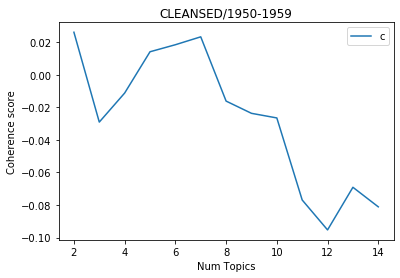

A maximum c_npmi score of 0.026215262777456554 was achieved at K=2
Number of topics = 2  has NPMI coherence Value of 0.0262
Number of topics = 3  has NPMI coherence Value of -0.029
Number of topics = 4  has NPMI coherence Value of -0.0112
Number of topics = 5  has NPMI coherence Value of 0.0142
Number of topics = 6  has NPMI coherence Value of 0.0185
Number of topics = 7  has NPMI coherence Value of 0.0234
Number of topics = 8  has NPMI coherence Value of -0.0161
Number of topics = 9  has NPMI coherence Value of -0.0236
Number of topics = 10  has NPMI coherence Value of -0.0265
Number of topics = 11  has NPMI coherence Value of -0.0769
Number of topics = 12  has NPMI coherence Value of -0.0953
Number of topics = 13  has NPMI coherence Value of -0.0691
Number of topics = 14  has NPMI coherence Value of -0.0811


In [15]:
best_model_index = draw_graph(start, limit, step, c_npmi)

## Save Final Model & Output

In [16]:
lda_model = model_list[best_model_index]
coherence_lda = c_npmi[best_model_index]
doc_lda = lda_model[corpus]
    
# Compute Perplexity - a measure of how good the model is; Lower the better.
perplexity = lda_model.log_perplexity(corpus)

# Write the results to a file
file_name = corpus_root.split("/")[1]
with open('LDA/'+file_name+'.txt', 'w') as f:
    f.write("Perplexity: "+str(perplexity)+"\nCoherence Score: "+str(coherence_lda))

# Save the visualizations
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(vis, 'LDA/'+file_name+'.html')

print("*"*20+"FINISHED "+corpus_root.split("/")[1]+"*"*20)

********************FINISHED 1950-1959********************


# 1960-1969

## Prepare Data

In [17]:
corpus_root = "CLEANSED/1960-1969"

# Read artciles
corpus = PlaintextCorpusReader(corpus_root, '.*txt')
rows = []
for text in corpus.fileids():
    article = corpus.raw(text)
    if len(article.split())>=10:
        rows.append([article])
    
# Create dataframe
df = pd.DataFrame.from_records(rows, columns=['content'])
# Convert to list
data_words_list = basic_cleaning(df['content'].values.tolist())

In [18]:
# Build the bigram model
bigram = gensim.models.Phrases(data_words_list, min_count=5, threshold=100) # higher threshold fewer phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram) # Faster way to get a sentence clubbed as a bigram
data_words_bigrams = [bigram_mod[doc] for doc in data_words_list] # Form Bigrams

In [19]:
# Do lemmatization
data_lemmatized = lemmatization(data_words_bigrams)
# Remove stop words, one word characters, and punctuations - again
final_data = []
for sent in data_lemmatized:
    words = []
    for item in sent:
        if (len(item)>3 or item=='ai') and (item not in stop or item=='ai'):
            words.append(item)
    final_data.append(' '.join(words))
data_lemmatized = list(map(lambda item:item.split(), final_data))

## Check Coherence

In [20]:
# CREATE THE DICTIONARY AND CORPUS NEEDED FOR TOPIC MODELING
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_lemmatized]

# CHECK COHERENCE
limit=15; start=2; step=1;
model_list, c_npmi = compute_coherence_values(dictionary=id2word, corpus=corpus, 
                                              texts=data_lemmatized, start=start, 
                                              limit=limit, step=step)

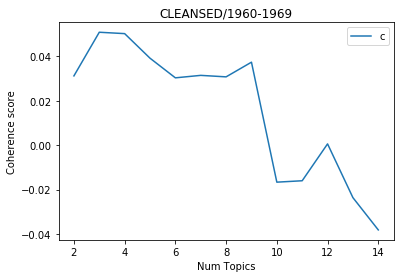

A maximum c_npmi score of 0.05086341502398273 was achieved at K=3
Number of topics = 2  has NPMI coherence Value of 0.0312
Number of topics = 3  has NPMI coherence Value of 0.0509
Number of topics = 4  has NPMI coherence Value of 0.0502
Number of topics = 5  has NPMI coherence Value of 0.0392
Number of topics = 6  has NPMI coherence Value of 0.0303
Number of topics = 7  has NPMI coherence Value of 0.0314
Number of topics = 8  has NPMI coherence Value of 0.0308
Number of topics = 9  has NPMI coherence Value of 0.0374
Number of topics = 10  has NPMI coherence Value of -0.0166
Number of topics = 11  has NPMI coherence Value of -0.016
Number of topics = 12  has NPMI coherence Value of 0.0006
Number of topics = 13  has NPMI coherence Value of -0.0236
Number of topics = 14  has NPMI coherence Value of -0.0381


In [21]:
best_model_index = draw_graph(start, limit, step, c_npmi)

## Save Final Model & Output

In [22]:
lda_model = model_list[best_model_index]
coherence_lda = c_npmi[best_model_index]
doc_lda = lda_model[corpus]
    
# Compute Perplexity - a measure of how good the model is; Lower the better.
perplexity = lda_model.log_perplexity(corpus)

# Write the results to a file
file_name = corpus_root.split("/")[1]
with open('LDA/'+file_name+'.txt', 'w') as f:
    f.write("Perplexity: "+str(perplexity)+"\nCoherence Score: "+str(coherence_lda))

# Save the visualizations
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(vis, 'LDA/'+file_name+'.html')

print("*"*20+"FINISHED "+corpus_root.split("/")[1]+"*"*20)

********************FINISHED 1960-1969********************


# 1970-1979

## Prepare Data

In [30]:
corpus_root = "CLEANSED/1970-1979"

# Read artciles
corpus = PlaintextCorpusReader(corpus_root, '.*txt')
rows = []
for text in corpus.fileids():
    article = corpus.raw(text)
    if len(article.split())>=10:
        rows.append([article])
    
# Create dataframe
df = pd.DataFrame.from_records(rows, columns=['content'])
# Convert to list
data_words_list = basic_cleaning(df['content'].values.tolist())

In [31]:
# Build the bigram model
bigram = gensim.models.Phrases(data_words_list, min_count=5, threshold=100) # higher threshold fewer phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram) # Faster way to get a sentence clubbed as a bigram
data_words_bigrams = [bigram_mod[doc] for doc in data_words_list] # Form Bigrams

In [32]:
# Do lemmatization
data_lemmatized = lemmatization(data_words_bigrams)
# Remove stop words, one word characters, and punctuations - again
final_data = []
for sent in data_lemmatized:
    words = []
    for item in sent:
        if (len(item)>3 or item=='ai') and (item not in stop or item=='ai'):
            words.append(item)
    final_data.append(' '.join(words))
data_lemmatized = list(map(lambda item:item.split(), final_data))

## Check Coherence

In [33]:
# CREATE THE DICTIONARY AND CORPUS NEEDED FOR TOPIC MODELING
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_lemmatized]

# CHECK COHERENCE
limit=15; start=2; step=1;
model_list, c_npmi = compute_coherence_values(dictionary=id2word, corpus=corpus, 
                                              texts=data_lemmatized, start=start, 
                                              limit=limit, step=step)

2022-08-14 07:02:25,142 : ERROR : worker encountered unexpected exception
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/gensim/topic_coherence/text_analysis.py", line 561, in run
    self._run()
  File "/opt/conda/lib/python3.7/site-packages/gensim/topic_coherence/text_analysis.py", line 581, in _run
    self.accumulator.partial_accumulate(docs, self.window_size)
  File "/opt/conda/lib/python3.7/site-packages/gensim/topic_coherence/text_analysis.py", line 353, in partial_accumulate
    super(WordOccurrenceAccumulator, self).accumulate(texts, window_size)
  File "/opt/conda/lib/python3.7/site-packages/gensim/topic_coherence/text_analysis.py", line 296, in accumulate
    self.analyze_text(virtual_document, doc_num)
  File "/opt/conda/lib/python3.7/site-packages/gensim/topic_coherence/text_analysis.py", line 360, in analyze_text
    self._slide_window(window, doc_num)
  File "/opt/conda/lib/python3.7/site-packages/gensim/topic_coherence/text_analysis.py

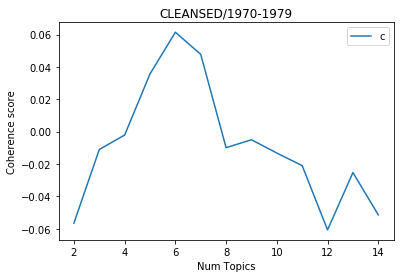

A maximum c_npmi score of 0.06140699507140084 was achieved at K=6
Number of topics = 2  has NPMI coherence Value of -0.0565
Number of topics = 3  has NPMI coherence Value of -0.011
Number of topics = 4  has NPMI coherence Value of -0.0021
Number of topics = 5  has NPMI coherence Value of 0.0357
Number of topics = 6  has NPMI coherence Value of 0.0614
Number of topics = 7  has NPMI coherence Value of 0.0477
Number of topics = 8  has NPMI coherence Value of -0.0099
Number of topics = 9  has NPMI coherence Value of -0.005
Number of topics = 10  has NPMI coherence Value of -0.0132
Number of topics = 11  has NPMI coherence Value of -0.021
Number of topics = 12  has NPMI coherence Value of -0.0607
Number of topics = 13  has NPMI coherence Value of -0.0253
Number of topics = 14  has NPMI coherence Value of -0.0514


In [34]:
best_model_index = draw_graph(start, limit, step, c_npmi)

## Save Final Model & Output

In [35]:
lda_model = model_list[best_model_index]
coherence_lda = c_npmi[best_model_index]
doc_lda = lda_model[corpus]
    
# Compute Perplexity - a measure of how good the model is; Lower the better.
perplexity = lda_model.log_perplexity(corpus)

# Write the results to a file
file_name = corpus_root.split("/")[1]
with open('LDA/'+file_name+'.txt', 'w') as f:
    f.write("Perplexity: "+str(perplexity)+"\nCoherence Score: "+str(coherence_lda))

# Save the visualizations
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(vis, 'LDA/'+file_name+'.html')

print("*"*20+"FINISHED "+corpus_root.split("/")[1]+"*"*20)

********************FINISHED 1970-1979********************


# 1980-1989

## Prepare Data

In [27]:
corpus_root = "CLEANSED/1980-1989"

# Read artciles
corpus = PlaintextCorpusReader(corpus_root, '.*txt')
rows = []
for text in corpus.fileids():
    article = corpus.raw(text)
    if len(article.split())>=10:
        rows.append([article])
    
# Create dataframe
df = pd.DataFrame.from_records(rows, columns=['content'])
# Convert to list
data_words_list = basic_cleaning(df['content'].values.tolist())

In [28]:
# Build the bigram model
bigram = gensim.models.Phrases(data_words_list, min_count=5, threshold=100) # higher threshold fewer phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram) # Faster way to get a sentence clubbed as a bigram
data_words_bigrams = [bigram_mod[doc] for doc in data_words_list] # Form Bigrams

In [29]:
# Do lemmatization
data_lemmatized = lemmatization(data_words_bigrams)
# Remove stop words, one word characters, and punctuations - again
final_data = []
for sent in data_lemmatized:
    words = []
    for item in sent:
        if (len(item)>3 or item=='ai') and (item not in stop or item=='ai'):
            words.append(item)
    final_data.append(' '.join(words))
data_lemmatized = list(map(lambda item:item.split(), final_data))

## Check Coherence

In [30]:
# CREATE THE DICTIONARY AND CORPUS NEEDED FOR TOPIC MODELING
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_lemmatized]

# CHECK COHERENCE
limit=15; start=2; step=1;
model_list, c_npmi = compute_coherence_values(dictionary=id2word, corpus=corpus, 
                                              texts=data_lemmatized, start=start, 
                                              limit=limit, step=step)

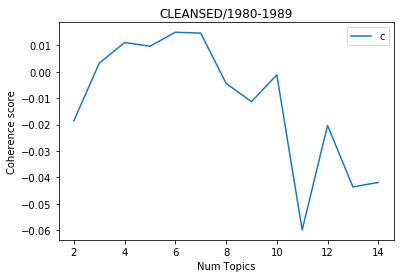

A maximum c_npmi score of 0.014934924834056234 was achieved at K=6
Number of topics = 2  has NPMI coherence Value of -0.0185
Number of topics = 3  has NPMI coherence Value of 0.0032
Number of topics = 4  has NPMI coherence Value of 0.011
Number of topics = 5  has NPMI coherence Value of 0.0096
Number of topics = 6  has NPMI coherence Value of 0.0149
Number of topics = 7  has NPMI coherence Value of 0.0146
Number of topics = 8  has NPMI coherence Value of -0.0044
Number of topics = 9  has NPMI coherence Value of -0.0113
Number of topics = 10  has NPMI coherence Value of -0.0012
Number of topics = 11  has NPMI coherence Value of -0.0599
Number of topics = 12  has NPMI coherence Value of -0.0203
Number of topics = 13  has NPMI coherence Value of -0.0436
Number of topics = 14  has NPMI coherence Value of -0.0419


In [31]:
best_model_index = draw_graph(start, limit, step, c_npmi)

## Save Final Model & Output

In [32]:
lda_model = model_list[best_model_index]
coherence_lda = c_npmi[best_model_index]
doc_lda = lda_model[corpus]
    
# Compute Perplexity - a measure of how good the model is; Lower the better.
perplexity = lda_model.log_perplexity(corpus)

# Write the results to a file
file_name = corpus_root.split("/")[1]
with open('LDA/'+file_name+'.txt', 'w') as f:
    f.write("Perplexity: "+str(perplexity)+"\nCoherence Score: "+str(coherence_lda))

# Save the visualizations
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(vis, 'LDA/'+file_name+'.html')

print("*"*20+"FINISHED "+corpus_root.split("/")[1]+"*"*20)

********************FINISHED 1980-1989********************


# 1990-1999

## Prepare Data

In [33]:
corpus_root = "CLEANSED/1990-1999"

# Read artciles
corpus = PlaintextCorpusReader(corpus_root, '.*txt')
rows = []
for text in corpus.fileids():
    article = corpus.raw(text)
    if len(article.split())>=10:
        rows.append([article])
    
# Create dataframe
df = pd.DataFrame.from_records(rows, columns=['content'])
# Convert to list
data_words_list = basic_cleaning(df['content'].values.tolist())

In [34]:
# Build the bigram model
bigram = gensim.models.Phrases(data_words_list, min_count=5, threshold=100) # higher threshold fewer phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram) # Faster way to get a sentence clubbed as a bigram
data_words_bigrams = [bigram_mod[doc] for doc in data_words_list] # Form Bigrams

In [35]:
# Do lemmatization
data_lemmatized = lemmatization(data_words_bigrams)
# Remove stop words, one word characters, and punctuations - again
final_data = []
for sent in data_lemmatized:
    words = []
    for item in sent:
        if (len(item)>3 or item=='ai') and (item not in stop or item=='ai'):
            words.append(item)
    final_data.append(' '.join(words))
data_lemmatized = list(map(lambda item:item.split(), final_data))

## Check Coherence

In [36]:
# CREATE THE DICTIONARY AND CORPUS NEEDED FOR TOPIC MODELING
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_lemmatized]

# CHECK COHERENCE
limit=15; start=2; step=1;
model_list, c_npmi = compute_coherence_values(dictionary=id2word, corpus=corpus, 
                                              texts=data_lemmatized, start=start, 
                                              limit=limit, step=step)

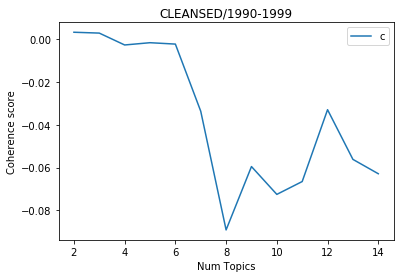

A maximum c_npmi score of 0.0033318483429155303 was achieved at K=2
Number of topics = 2  has NPMI coherence Value of 0.0033
Number of topics = 3  has NPMI coherence Value of 0.0029
Number of topics = 4  has NPMI coherence Value of -0.0026
Number of topics = 5  has NPMI coherence Value of -0.0016
Number of topics = 6  has NPMI coherence Value of -0.0022
Number of topics = 7  has NPMI coherence Value of -0.0336
Number of topics = 8  has NPMI coherence Value of -0.0891
Number of topics = 9  has NPMI coherence Value of -0.0595
Number of topics = 10  has NPMI coherence Value of -0.0725
Number of topics = 11  has NPMI coherence Value of -0.0665
Number of topics = 12  has NPMI coherence Value of -0.0329
Number of topics = 13  has NPMI coherence Value of -0.0561
Number of topics = 14  has NPMI coherence Value of -0.0628


In [37]:
best_model_index = draw_graph(start, limit, step, c_npmi)

## Save Final Model & Output

In [38]:
lda_model = model_list[best_model_index]
coherence_lda = c_npmi[best_model_index]
doc_lda = lda_model[corpus]
    
# Compute Perplexity - a measure of how good the model is; Lower the better.
perplexity = lda_model.log_perplexity(corpus)

# Write the results to a file
file_name = corpus_root.split("/")[1]
with open('LDA/'+file_name+'.txt', 'w') as f:
    f.write("Perplexity: "+str(perplexity)+"\nCoherence Score: "+str(coherence_lda))

# Save the visualizations
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(vis, 'LDA/'+file_name+'.html')

print("*"*20+"FINISHED "+corpus_root.split("/")[1]+"*"*20)

********************FINISHED 1990-1999********************


# 2000-2009

## Prepare Data

In [39]:
corpus_root = "CLEANSED/2000-2009"

# Read artciles
corpus = PlaintextCorpusReader(corpus_root, '.*txt')
rows = []
for text in corpus.fileids():
    article = corpus.raw(text)
    if len(article.split())>=10:
        rows.append([article])
    
# Create dataframe
df = pd.DataFrame.from_records(rows, columns=['content'])
# Convert to list
data_words_list = basic_cleaning(df['content'].values.tolist())

In [40]:
# Build the bigram model
bigram = gensim.models.Phrases(data_words_list, min_count=5, threshold=100) # higher threshold fewer phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram) # Faster way to get a sentence clubbed as a bigram
data_words_bigrams = [bigram_mod[doc] for doc in data_words_list] # Form Bigrams

In [41]:
# Do lemmatization
data_lemmatized = lemmatization(data_words_bigrams)
# Remove stop words, one word characters, and punctuations - again
final_data = []
for sent in data_lemmatized:
    words = []
    for item in sent:
        if (len(item)>3 or item=='ai') and (item not in stop or item=='ai'):
            words.append(item)
    final_data.append(' '.join(words))
data_lemmatized = list(map(lambda item:item.split(), final_data))

## Check Coherence

In [42]:
# CREATE THE DICTIONARY AND CORPUS NEEDED FOR TOPIC MODELING
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_lemmatized]

# CHECK COHERENCE
limit=15; start=2; step=1;
model_list, c_npmi = compute_coherence_values(dictionary=id2word, corpus=corpus, 
                                              texts=data_lemmatized, start=start, 
                                              limit=limit, step=step)

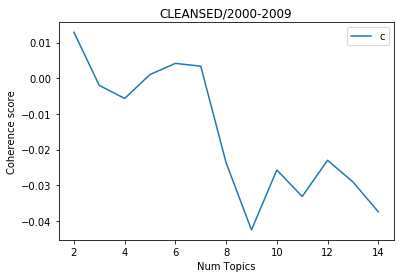

A maximum c_npmi score of 0.012880097263677453 was achieved at K=2
Number of topics = 2  has NPMI coherence Value of 0.0129
Number of topics = 3  has NPMI coherence Value of -0.002
Number of topics = 4  has NPMI coherence Value of -0.0057
Number of topics = 5  has NPMI coherence Value of 0.001
Number of topics = 6  has NPMI coherence Value of 0.0041
Number of topics = 7  has NPMI coherence Value of 0.0034
Number of topics = 8  has NPMI coherence Value of -0.0237
Number of topics = 9  has NPMI coherence Value of -0.0425
Number of topics = 10  has NPMI coherence Value of -0.0257
Number of topics = 11  has NPMI coherence Value of -0.0332
Number of topics = 12  has NPMI coherence Value of -0.023
Number of topics = 13  has NPMI coherence Value of -0.0291
Number of topics = 14  has NPMI coherence Value of -0.0375


In [43]:
best_model_index = draw_graph(start, limit, step, c_npmi)

## Save Final Model & Output

In [44]:
lda_model = model_list[best_model_index]
coherence_lda = c_npmi[best_model_index]
doc_lda = lda_model[corpus]
    
# Compute Perplexity - a measure of how good the model is; Lower the better.
perplexity = lda_model.log_perplexity(corpus)

# Write the results to a file
file_name = corpus_root.split("/")[1]
with open('LDA/'+file_name+'.txt', 'w') as f:
    f.write("Perplexity: "+str(perplexity)+"\nCoherence Score: "+str(coherence_lda))

# Save the visualizations
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(vis, 'LDA/'+file_name+'.html')

print("*"*20+"FINISHED "+corpus_root.split("/")[1]+"*"*20)

********************FINISHED 2000-2009********************


# 2010-2019

## Prepare Data

In [45]:
corpus_root = "CLEANSED/2010-2019"

# Read artciles
corpus = PlaintextCorpusReader(corpus_root, '.*txt')
rows = []
for text in corpus.fileids():
    article = corpus.raw(text)
    if len(article.split())>=10:
        rows.append([article])
    
# Create dataframe
df = pd.DataFrame.from_records(rows, columns=['content'])
# Convert to list
data_words_list = basic_cleaning(df['content'].values.tolist())

In [46]:
# Build the bigram model
bigram = gensim.models.Phrases(data_words_list, min_count=5, threshold=100) # higher threshold fewer phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram) # Faster way to get a sentence clubbed as a bigram
data_words_bigrams = [bigram_mod[doc] for doc in data_words_list] # Form Bigrams

In [47]:
# Do lemmatization
data_lemmatized = lemmatization(data_words_bigrams)
# Remove stop words, one word characters, and punctuations - again
final_data = []
for sent in data_lemmatized:
    words = []
    for item in sent:
        if (len(item)>3 or item=='ai') and (item not in stop or item=='ai'):
            words.append(item)
    final_data.append(' '.join(words))
data_lemmatized = list(map(lambda item:item.split(), final_data))

## Check Coherence

In [48]:
# CREATE THE DICTIONARY AND CORPUS NEEDED FOR TOPIC MODELING
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_lemmatized]

# CHECK COHERENCE
limit=15; start=2; step=1;
model_list, c_npmi = compute_coherence_values(dictionary=id2word, corpus=corpus, 
                                              texts=data_lemmatized, start=start, 
                                              limit=limit, step=step)

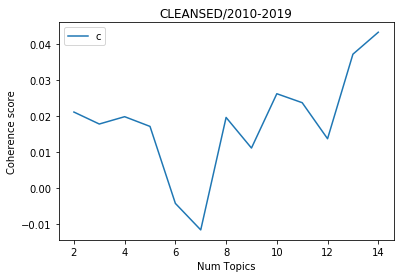

A maximum c_npmi score of 0.04324810303301451 was achieved at K=14
Number of topics = 2  has NPMI coherence Value of 0.0211
Number of topics = 3  has NPMI coherence Value of 0.0178
Number of topics = 4  has NPMI coherence Value of 0.0198
Number of topics = 5  has NPMI coherence Value of 0.0171
Number of topics = 6  has NPMI coherence Value of -0.0043
Number of topics = 7  has NPMI coherence Value of -0.0117
Number of topics = 8  has NPMI coherence Value of 0.0196
Number of topics = 9  has NPMI coherence Value of 0.0111
Number of topics = 10  has NPMI coherence Value of 0.0262
Number of topics = 11  has NPMI coherence Value of 0.0237
Number of topics = 12  has NPMI coherence Value of 0.0137
Number of topics = 13  has NPMI coherence Value of 0.0371
Number of topics = 14  has NPMI coherence Value of 0.0432


In [49]:
best_model_index = draw_graph(start, limit, step, c_npmi)

## Save Final Model & Output

In [50]:
lda_model = model_list[best_model_index]
coherence_lda = c_npmi[best_model_index]
doc_lda = lda_model[corpus]
    
# Compute Perplexity - a measure of how good the model is; Lower the better.
perplexity = lda_model.log_perplexity(corpus)

# Write the results to a file
file_name = corpus_root.split("/")[1]
with open('LDA/'+file_name+'.txt', 'w') as f:
    f.write("Perplexity: "+str(perplexity)+"\nCoherence Score: "+str(coherence_lda))

# Save the visualizations
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(vis, 'LDA/'+file_name+'.html')

print("*"*20+"FINISHED "+corpus_root.split("/")[1]+"*"*20)

********************FINISHED 2010-2019********************


## Save Final Model & Output

In [51]:
lda_model = model_list[best_model_index]
coherence_lda = c_npmi[best_model_index]
doc_lda = lda_model[corpus]
    
# Compute Perplexity - a measure of how good the model is; Lower the better.
perplexity = lda_model.log_perplexity(corpus)

# Write the results to a file
file_name = corpus_root.split("/")[1]
with open('LDA/'+file_name+'.txt', 'w') as f:
    f.write("Perplexity: "+str(perplexity)+"\nCoherence Score: "+str(coherence_lda))

# Save the visualizations
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
pyLDAvis.save_html(vis, 'LDA/'+file_name+'.html')

print("*"*20+"FINISHED "+corpus_root.split("/")[1]+"*"*20)

********************FINISHED 2010-2019********************


# Others

## Finding the dominant topic in each sentence

One of the practical application of topic modeling is to determine what topic a given document is about.

To find that, we find the topic number that has the highest percentage contribution in that document.

In [ ]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [ ]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

## Find the most representative document for each topic

Sometimes just the topic keywords may not be enough to make sense of what a topic is about. 

So, to help with understanding the topic, you can find the documents a given topic has contributed to the most and infer the topic by reading that document.

In [ ]:
# Group top 5 sentences under each topic
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                      grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                     axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf.head()

The above has the topic number, the keywords, and the most representative document. The Perc_Contribution column is nothing but the percentage contribution of the topic in the given document.

## Topic distribution across documents

Finally, we want to understand the volume and distribution of topics in order to judge how widely it was discussed. The below table exposes that information.

In [ ]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics